In [1]:
import numpy as np

import jax
from jax import jit
import jax.numpy as jnp
from jax import grad, random, vmap
from jax.scipy.linalg import solve_triangular
import optax

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from utils import *
from kernels import * 
from kernel_sca_inducing_points import *

import wandb

from jPCA.util import load_churchland_data, plot_projections


In [ ]:
seed = 42
key = random.PRNGKey(seed)

num_trajectories = 200
time_steps = 50

time = jnp.linspace(0, 2 *jnp.pi, time_steps)[:, jnp.newaxis]
radii = jnp.linspace(0.1, 2, num_trajectories)
radii = random.permutation(key, radii)
phases = jnp.linspace(0, 2*jnp.pi, num_trajectories)

# sine_waves = jnp.sin(time + phases) * radii
# cosine_waves = jnp.cos(time + phases) * radii
# X = jnp.stack([cosine_waves.T, sine_waves.T], axis=1)   #K=50, N=2, T=200

r = radii * jnp.cos(time + phases)
theta = radii * jnp.sin(time + phases)
x = r * np.cos(theta)
y = r * np.sin(theta)
X = jnp.stack([x.T, y.T], axis=1)
K, N, T = X.shape


# proj_dims = 10
# proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
# proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)
# X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)
# noise = random.normal(key, (X.shape)) 
# X += 0.01 * (noise)  

# split = 1
# X_train = X[split:]
# X_test = X[:split]
# K, N, T = X_train.shape

A = jnp.swapaxes(X, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                              #(N, K*T)

#plot_2D(X_train)

In [ ]:
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=100, learning_rate=0.1, d=2, c=30, kernel_function=K_X_Y_squared_exponential)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

In [5]:
#X_init = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/Churchland/churchland.npy')
X_init = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy').swapaxes(1,2)
d = 3

X, _ = pre_processing(X_init, center=False, soft_normalize='max')
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                        #(N, K*T)

wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=100, learning_rate=0.1, d=3, c=30, kernel_function=K_X_Y_rational_quadratic)
wandb.finish()

Iteration 0, S: 0.0751551166176796, S_ratio: 0.30867475271224976
Iteration 10, S: 4.861936569213867, S_ratio: 0.41046279668807983
Iteration 20, S: 6.861271858215332, S_ratio: 0.41824015974998474
Iteration 30, S: 9.334127426147461, S_ratio: 0.4229809641838074
Iteration 40, S: 10.061662673950195, S_ratio: 0.41981837153434753
Iteration 50, S: 10.860540390014648, S_ratio: 0.42802944779396057
Iteration 60, S: 10.951801300048828, S_ratio: 0.4220099151134491
Iteration 70, S: 8.788188934326172, S_ratio: 0.42140433192253113
Iteration 80, S: 9.90186882019043, S_ratio: 0.4255110025405884
Iteration 90, S: 11.183809280395508, S_ratio: 0.4337516725063324


Text(0.5, 0.92, 's = 0.42961516976356506')

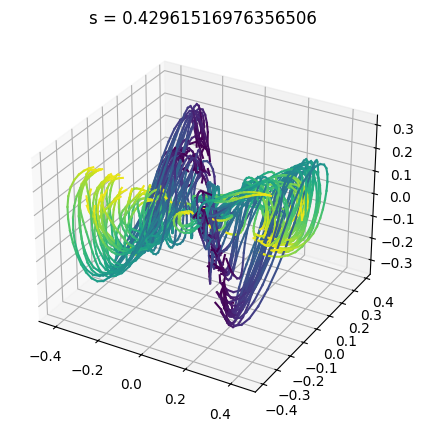

In [6]:
kernel_function=K_X_Y_rational_quadratic
c=30
d = 3
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H  = get_alpha(params, A, X, kernel_function, d)


X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

plot_3D(Y[:,:,:])
plt.title(f's = {compute_S_all_pairs(Y)}')

#plt.title(f's = {np.mean(compute_S(projection))}')
# plt.figure()
# plt.plot(projection[0,0,:])
# plt.plot(projection[0,1,:])

In [7]:
np.save('Y', Y)

In [ ]:
print(l2)


In [ ]:
K_A_u =  K_X_Y_squared_exponential(A, u, l = l, sigma_f=sigma_f)    
K_A_A_low_rank = jnp.einsum('kc,cj,mj ->km',  K_A_u, K_u_u_inv, K_A_u)
K_A_A_exact = K_X_Y_squared_exponential(A, A ,l=l, sigma_f=sigma_f)
# K_A_A_reshaped = K_A_A_exact.reshape(K,T,K,T)   
# means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
# K_A_A_tilde_exact = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)

plt.subplot(121)
plt.imshow(K_A_A_exact)
plt.colorbar()
plt.subplot(122)
plt.imshow(K_A_A_low_rank)
plt.colorbar()
#nmse = jnp.mean( (K_A_A_tilde_exact - K_A_A_low_rank)**2) / jnp.mean(K_A_A_exact**2)
#plt.suptitle(f' NMSE = {nmse}' )
plt.subplots_adjust(wspace=0.8)


# K_A_X_exact = np.zeros((K*T, K, T))
# for k in range(K):
#     K_A_X_exact[:,k,:] = K_X_Y_squared_exponential(A, X[k]) # l=l, sigma_f=sigma_f

# plt.figure()
# plt.subplot(121)
# plt.imshow(K_A_X_exact[:,0,:],aspect='auto')
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(K_A_X[:,0,:], aspect='auto')
# plt.colorbar()
# nmse = jnp.mean( (K_A_X_exact - K_A_X)**2) / jnp.mean(K_A_X_exact**2)
# plt.suptitle(f' NMSE = {nmse}' )
# plt.subplots_adjust(wspace=0.8)


In [ ]:
plt.imshow(H_K_A_u, aspect='auto')
plt.title('H_K_A_u')
plt.colorbar()

plt.figure()
plt.imshow( K_u_u , aspect='auto' )
plt.title('K_u_u')
plt.colorbar()

plt.figure()
plt.imshow( H_K_A_u @ jnp.linalg.inv(K_u_u) @ H_K_A_u.T, aspect='auto' )
plt.title('K_A_A_approx')
plt.colorbar()

ENDS HERE

In [ ]:
    #SVD
    # K_A_A = kernel_function(A, A, l=l, sigma_f=sigma_f)
    # K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
    # means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
    # K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
    # P, S, _ = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)
    # # num_components = 10
    # # P = P[:, :num_components]
    # # S = S[:num_components]
    
    # alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
    # alpha = (P / jnp.sqrt(S+1e-1)) @ alpha_tilde_QR

    #QR
    # K_A_A = kernel_function(A, A, l=l, sigma_f=sigma_f)
    # K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
    # means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
    # K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
    # Q, R = jnp.linalg.qr(K_A_A_tilde)                                #Q and R are (K*T, K*T)
    # alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
    # #alpha = Q @ jnp.linalg.inv(R.T) @ alpha_tilde_QR                 #Q @ triangular_solve(R.T, alpha_tilde_QR, lower=True)
    # R_inv_transpose = triangular_solve(R.T, jnp.eye(R.shape[0]), lower=True)
    # alpha = Q @ R_inv_transpose @ alpha_tilde_QR


    #QR
    # K_A_A = kernel_function(A, A, l=l, sigma_f=sigma_f)
    # K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
    # means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
    # K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
    # Q, R = jnp.linalg.qr(K_A_A_tilde)                                #Q and R are (K*T, K*T)
    # #Q_truncated = Q[:, :c]
    # #R_truncated = R[:c, :]
    # alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
    # alpha = Q @ jnp.linalg.inv(R.T) @ alpha_tilde_QR
    # H_K_A_u = None
    # K_A_u = None 
    # K_u_u = None

In [ ]:
# K_A_A = K_X_Y_squared_exponential(A, A)
# K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
# means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
# K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
# Q, R = jnp.linalg.qr(K_A_A) 

# alpha_tilde = random.normal(key, (K*T, 3))
# alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
# alpha = Q @ jnp.linalg.inv(R.T) @ alpha_tilde_QR                 #Q @ triangular_solve(R.T, alpha_tilde_QR, lower=True)



# K_A_A = K_X_Y_squared_exponential(A, A)
# K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
# means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
# K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
# P, S, _ = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)
# num_components = 10
# P = P[:, :num_components]
# S = S[:num_components]

In [ ]:
K_A_u =  K_X_Y_squared_exponential(A, u)               #(K*T, c)
K_u_u =  K_X_Y_squared_exponential(u, u)               #(c, c)
K_A_A = K_A_u @ K_u_u @ K_A_u.T
L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-6)
jnp.allclose(K_u_u, L @ L.T)

alpha_tilde = random.normal(key, (c, 3))
Q, R = jnp.linalg.qr(K_A_u, mode='reduced') 
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
#L_alpha = jnp.dot(L, alpha_tilde_QR)
#alpha = Q @ triangular_solve(R.T, L_alpha, lower=True)
#Q @ jnp.linalg.inv(R.T) @ L @ alpha_tilde_QR                               #(K*T, c) @ (c, c) @ (c, c) @ (c, d)
#R_inv_transpose = triangular_solve(R.T, jnp.eye(R.shape[0]), lower=True)

alpha = jnp.einsum('kc, cl, lj, jd -> kd', Q, triangular_solve(R.T, jnp.eye(R.shape[0]), lower=True), L, alpha_tilde_QR) 

# K_u_X_i =  K_X_Y_squared_exponential(u, X[0])                       #(c, K, T)
# K_X_u_i =  K_X_Y_squared_exponential(u, X[0]).T

# K_A_X_i = jnp.einsum('kc,cj,jm ->km',  K_A_u, K_u_u, K_u_X_i) 
# K_X_A_i = jnp.einsum('kc,cj,mj ->km',  K_X_u_i, K_u_u, K_A_u) 

In [ ]:
# K_u_X = jnp.zeros((c, K, T))
# for k in range(K):
#     K_u_X = K_u_X.at[:, k, :].set(K_X_Y_squared_exponential(u, X[k], l=l, sigma_f=sigma_f))


K_A_u =  K_X_Y_squared_exponential(A, u)               #(K*T, c)
K_u_u =  K_X_Y_squared_exponential(u, u)               #(c, c)
K_A_A = K_A_u @ K_u_u @ K_A_u.T
L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-6)
jnp.allclose(K_u_u, L @ L.T)

alpha_tilde = random.normal(key, (c, 3))
Q, R = jnp.linalg.qr(K_A_u, mode='reduced') 
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 

alpha = jnp.einsum('kc, cl, lj, jd -> kd', Q, triangular_solve(R.T, jnp.eye(R.shape[0]), lower=True), L, alpha_tilde_QR) 

K_A_A = jnp.einsum('kc,cj,mj ->km',  K_A_u, K_u_u, K_A_u)
# K_u_X_i =  K_X_Y_squared_exponential(u, X[0])                       #(c, K, T)
# K_X_u_i =  K_X_Y_squared_exponential(u, X[0]).T

# K_A_X_i = jnp.einsum('kc,cj,jm ->km',  K_A_u, K_u_u, K_u_X_i) 
# K_X_A_i = jnp.einsum('kc,cj,mj ->km',  K_X_u_i, K_u_u, K_A_u) 


# delta_xz = jnp.eye(len(X))  # Assuming X and Z are the same for simplification of the Kronecker delta
# k_fitc = K_A_A + jnp.eye(K_A_A.shape[0]) * (K_X_Y_squared_exponential(A, A) - K_A_A)

In [ ]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)
print( kernel(A.T,A.T, l=5,  sigma_f=10) )

In [ ]:
K_A_u =  K_X_Y_squared_exponential(A, u)               #(K*T, c)
K_u_u =  K_X_Y_squared_exponential(u, u)               #(c, c)
K_A_A = K_A_u @ K_u_u @ K_A_u.T
L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-6)
K_u_u_inv = triangular_solve(K_u_u, jnp.eye(K_u_u.shape[0]))
#K_u_u_inv = jnp.linalg.inv(K_u_u)
K_u_u_inv

In [ ]:
projection_ls = []
for i in range(projection.shape[0]):
    projection_ls.append(projection[i].T)
plt.figure()
plot_projections(projection_ls)

In [ ]:
c=5

indices = jax.random.choice(key, A.shape[1], shape=(c,), replace=False)
u = A[:, indices]    

K_A_u =  K_X_Y_squared_exponential(A, u)               #(K*T, c)
K_u_u =  K_X_Y_squared_exponential(u, u)               #(c, c)
K_A_A = K_A_u @ K_u_u @ K_A_u.T
L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-6)
jnp.allclose(K_u_u, L @ L.T)

alpha_tilde = random.normal(key, (c, 3))
Q, R = jnp.linalg.qr(K_A_u, mode='reduced') 
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 

K_A_u_reshaped = K_A_u.reshape(K,T,c)                                #(K, T, c)
mean = jnp.mean(K_A_u_reshaped, axis=(0), keepdims=True)             #(1, T, c)
H_K_A_u = (K_A_u_reshaped - mean).reshape(K*T,c)                     #(K*T,c)           #K_A_A = jnp.einsum('kc,cj,mj ->km',  H_K_A_u, jnp.linalg.inv(K_u_u), H_K_A_u)       #K_A_u @ K_u_u @ K_A_u.T (K*T, K*T)

L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-5)
Q_, R = jnp.linalg.qr(H_K_A_u, mode='reduced')                                                                                        #(mode reduced Q(kt, c) R(c,c) versus complete Q (kt,kt) and R(KT, c))
    
tmp = solve_triangular(L, H_K_A_u.T, lower=True)
K_u_u_K_u_A = solve_triangular(L.T, tmp, lower=False)

alpha = jnp.einsum('ij,jm->im', Q_, solve_triangular(R.T, jnp.dot(L, alpha_tilde_QR), lower=True))   

K_u_u_K_u_A_alpha_H =  jnp.einsum('ij,jm->im',  K_u_u_K_u_A, alpha)   #(c, d)
K_u_X_i =  K_X_Y_squared_exponential(u, X[0])                     #(c,T)      
K_X_u_i =  K_X_Y_squared_exponential(u, X[0])
#Q = jnp.einsum('dk,kt,tj,jm->dm', K_u_u_K_u_A_alpha_H, K_u_X_i, K_X_u_i, K_u_u_K_u_A_alpha_H)

In [ ]:
c=5
d=2

indices = jax.random.choice(key, A.shape[1], shape=(c,), replace=False)
u = A[:, indices] 

K_A_u =  K_X_Y_squared_exponential(A, u)               #(K*T, c)
K_u_u =  K_X_Y_squared_exponential(u, u)               #(c, c)
K_A_A = K_A_u @ K_u_u @ K_A_u.T
L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-6)
jnp.allclose(K_u_u, L @ L.T)

alpha_tilde = random.normal(key, (c, d))
Q, R = jnp.linalg.qr(K_A_u, mode='reduced') 
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 

K_A_u_reshaped = K_A_u.reshape(K,T,c)                                #(K, T, c)
mean = jnp.mean(K_A_u_reshaped, axis=(0), keepdims=True)             #(1, T, c)
H_K_A_u = (K_A_u_reshaped - mean).reshape(K*T,c)                     #(K*T,c)           #K_A_A = jnp.einsum('kc,cj,mj ->km',  H_K_A_u, jnp.linalg.inv(K_u_u), H_K_A_u)       #K_A_u @ K_u_u @ K_A_u.T (K*T, K*T)

L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-5)
Q_, R = jnp.linalg.qr(H_K_A_u, mode='reduced')                                                                                        #(mode reduced Q(kt, c) R(c,c) versus complete Q (kt,kt) and R(KT, c))
    
tmp = solve_triangular(L, H_K_A_u.T, lower=True)
K_u_u_K_u_A = solve_triangular(L.T, tmp, lower=False)

alpha = jnp.einsum('ij,jm->im', Q_, solve_triangular(R.T, jnp.dot(L, alpha_tilde_QR), lower=True))   

K_u_u_K_u_A_alpha_H =  jnp.einsum('ij,jm->im',  K_u_u_K_u_A, alpha)   #(c, d)


l2=1
kernel_function='gaussian'

num_pairs = 10
all_combinations = jnp.array(list(combinations(range(K), 2)))
indices = random.randint(key, shape=(num_pairs,), minval=0, maxval=all_combinations.shape[0])
index_pairs = all_combinations[indices]

print(X[ index_pairs[:, 1]].shape)
print(X.shape)

test = np.zeros((num_pairs, c , T))
for i in range( num_pairs):
    test[i,:,:] = K_X_Y_squared_exponential(u, X[index_pairs[:, 1]][i], l=l2)    

X1 = X[index_pairs[:, 0]].swapaxes(0,1).reshape(N,-1)
X2 = X[index_pairs[:, 1]].swapaxes(0,1).reshape(N,-1)
K_u_X1 = K_X_Y_squared_exponential(u, X1, l=l2).reshape(-1,num_pairs,T).swapaxes(0,1)    #(pairs, c, T)
K_u_X2 = K_X_Y_squared_exponential(u, X2, l=l2).reshape(-1,num_pairs,T).swapaxes(0,1)  

k1 = jnp.einsum('lji,jm->lim',  K_u_X1, K_u_u_K_u_A_alpha_H)                #(pair, T, d)
k2 = jnp.einsum('lji,jm->lim',  K_u_X2, K_u_u_K_u_A_alpha_H) 

Q = jnp.einsum('ktn,ltm->klnm', k1,k2)
term2 = jnp.einsum('klnm,klmn->', Q,Q)
term1 = jnp.square(jnp.einsum('klnn->kl', Q)).sum()

S = (2 / (num_pairs**2) ) * (term1-term2)